In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("AusAntidiabeticDrug.csv", index_col = "ds",
                 parse_dates = True,
                 dayfirst = False)
df.head()

,y
ds,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


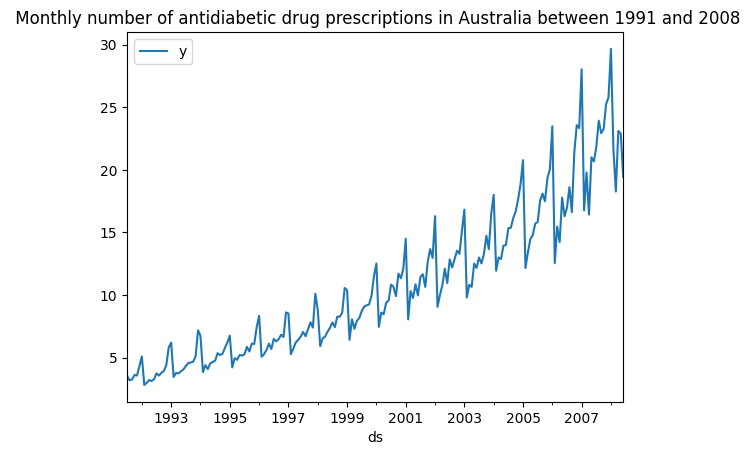

In [3]:
df.plot(title=" Monthly number of antidiabetic drug prescriptions in Australia between 1991 and 2008")
plt.show()

#### This time series shows the increasing trend and increasing seasonal variations over time. Specifically:

#### **1- Trend:** There is an increasing trend, which implies that the number of prescribed antidiabetic drugs has increased over the years in Australia.

#### **2- Seasonality:** The amplitude of the seasonal variations increases as the trend increases. The peaks and troughs in the data become more pronounced as the overall level of the series increases.

#### Based on these findings, this time series is more probably multiplicatively decomposed rather than additively. In the case of a multiplicative time series, the seasonal effect increases with time in the same way as it does in the plot produced.

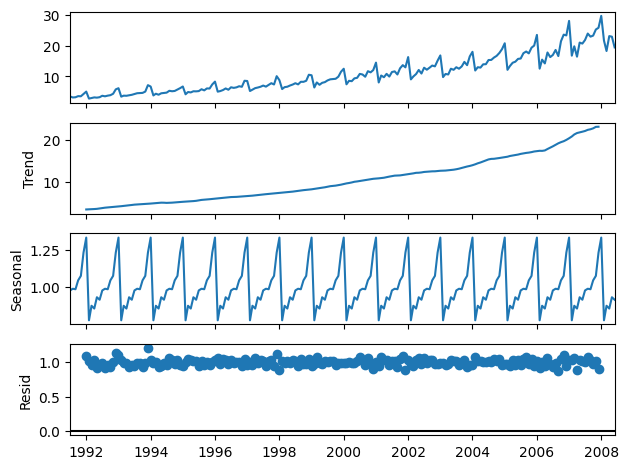

In [4]:
decomposition = seasonal_decompose(df, model='multiplicative',period=12)
decomposition.plot()
plt.show()

#### From above graph it can be seen that:
#### **Trend:** There is a strong upward trend, as already mentioned previously, reflecting the increase in the quantity of prescriptions with time. It may be caused by the increase in awareness, diagnoses, or other factors.
#### **Seasonality:** The seasonal component demonstrates clear regular spikes throughout the plot, presenting the regular pattern of prescription quantity across times of the year. The amplitude of these spikes varies, serving as the evidence of the multiplicative nature of the series.
#### **Residuals:** The residuals are fairly small and appear stochastic, indicating that the model successfully decomposes trend and seasonality.
#### The decomposition provides the evidence that the time series is, indeed, multiplicative, with the amplitude of the seasonal component increasing as the trend increases. 

#### After so far exploration, as we can see from first and second plot it is clear that there is seasonality and trend in the data. So to predict the future from this kind of data best way will be to use SARIMA model.

#### And it is also obvious that time series is non-stationary.
#### First lets confirm this assumption of non-stationarity by Dickey Fuller test

In [5]:
# lets apply dickey fuller test to check if the data is stationary or not
result = adfuller(df)

print("ADF Test Results:")
print(f"Test Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Lags Used: {result[2]}")
print(f"Number of Observations Used: {result[3]}")

print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

print(f"IC Best: {result[5]}")

ADF Test Results:
Test Statistic: 3.145185689306735
p-value: 1.0
Lags Used: 15
Number of Observations Used: 188
Critical Values:
   1%: -3.465620397124192
   5%: -2.8770397560752436
   10%: -2.5750324547306476
IC Best: 549.6705685364172


#### Dickey fuller test confirms that data is non-stationary as p-value is 1 which great than 0.05 and ADF statistic is also a greater number than critical values, so we cannot reject the null hypothesis.

#### So first lets make the dataset stationary.

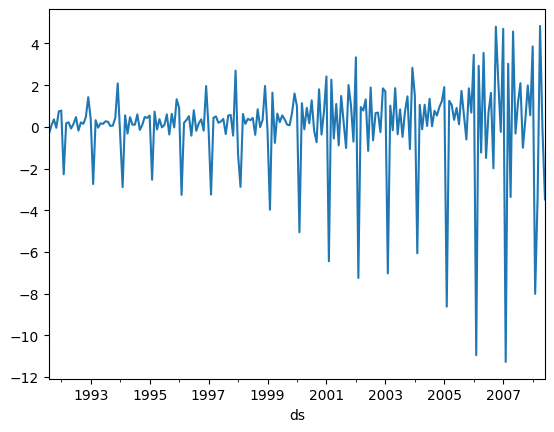

In [6]:
# lets make the data stationary
df['ds_diff'] = df['y'].diff()
df = df.dropna()
df['ds_diff'].plot()
plt.show()

#### From above image it looks like that dataset is stationary because it is fluctuating around mean zero, but need to cofirm this with dickey fuller test again.

In [7]:
result_1 = adfuller(df['ds_diff'])

print("ADF Test Results:")
print(f"Test Statistic: {result_1[0]}")
print(f"p-value: {result_1[1]}")
print(f"Lags Used: {result_1[2]}")
print(f"Number of Observations Used: {result_1[3]}")

print("Critical Values:")
for key, value in result_1[4].items():
    print(f"   {key}: {value}")

print(f"IC Best: {result_1[5]}")

ADF Test Results:
Test Statistic: -2.495172147449726
p-value: 0.11665341686469105
Lags Used: 15
Number of Observations Used: 187
Critical Values:
   1%: -3.465811691080702
   5%: -2.877123351472649
   10%: -2.5750770662586864
IC Best: 547.1880809726356


#### Dickey fuller test confirms that dataset is still not stationary. As in this data there is strong seasonal pattern so it is necessary to apply seasonal differencing on it.

C:\Users\rajar\AppData\Local\Temp\ipykernel_21348\2652471538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seasonal_diff'] = df['ds_diff'].diff(12)


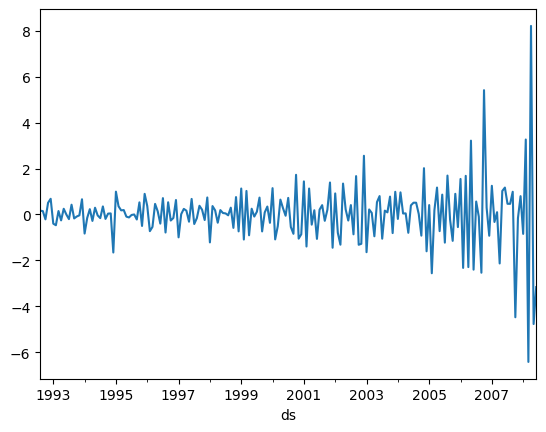

In [8]:
# lets apply seasoonal differencing
df['seasonal_diff'] = df['ds_diff'].diff(12)
df = df.dropna()
df['seasonal_diff'].plot()
plt.show()

#### Again from this visual it is not clear that data is stationary or not. so apply ADF test

In [9]:
result_2 = adfuller(df['seasonal_diff'])

print("ADF Test Results:")
print(f"Test Statistic: {result_2[0]}")
print(f"p-value: {result_2[1]}")
print(f"Lags Used: {result_2[2]}")
print(f"Number of Observations Used: {result_2[3]}")

print("Critical Values:")
for key, value in result_2[4].items():
    print(f"   {key}: {value}")

print(f"IC Best: {result_2[5]}")

ADF Test Results:
Test Statistic: -4.783439595647968
p-value: 5.849508608803843e-05
Lags Used: 12
Number of Observations Used: 178
Critical Values:
   1%: -3.467631519151906
   5%: -2.8779183721695567
   10%: -2.575501353364474
IC Best: 493.75357054933943


#### Now, the returned p-value is .849508608803843e-05. Thus, we can reject the null hypothesis and conclude that our time series is stationary.

#### For SARIMA model there are 6 paramters that need to be chosen, but so far we have chosen two of then one d=1 and other is D=1, becuase we only applied differencing for 1 time and also we applied seasonal differencing for only 1 time. other parameters p,q and P,Q will be calculated using AIC values p,q,P, and Q will be selected for final model.

### Lets first do test train split

In [17]:
test_size = 36
train_size = len(df) - test_size

train = df.iloc[:train_size]
test = df.iloc[train_size:]

,y,ds_diff,seasonal_diff
ds,,,
1992-08-01,3.558776,-0.179075,0.166625
1992-09-01,3.777202,0.218426,0.147096
1992-10-01,3.924490,0.147289,-0.211493
1992-11-01,4.386531,0.462041,0.507175
1992-12-01,5.810549,1.424018,0.683516
...,...,...,...
2005-02-01,12.154552,-8.624171,-2.558433
2005-03-01,13.402392,1.247840,0.187970
2005-04-01,14.459239,1.056847,1.172102


#### **Lets apply SARIMA model.**
#### First need to find the best parameters for SARIMA model which are p,q,d,D,P, and Q.
#### From our previous stationary process, as we differenced the time series only once then d=1. And also we applied seasonal differencing for once so D = 1 again.
#### For remaining parameters we will apply a function which will perform a grid search to find the best SARIMAX model parameters by evaluating different combinations based on the lowest Akaike Information Criterion (AIC).

"Following code is taken from book "Time Series Forecasting in Python by Marco Peixeiro"

In [14]:
from itertools import product
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
order_list = list(product(ps, qs, Ps, Qs))
d = 1
D = 1
s = 12

In [15]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
            endog,
            exog,
            order=(order[0], d, order[1]),
            seasonal_order=(order[2], D, order[3], s),
            simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, model.aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
#Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC',
    ascending=True).reset_index(drop=True)
    return result_df

In [18]:
SARIMA_result_df = optimize_SARIMAX(train['y'], None, order_list, d,D, s)
SARIMA_result_df

C:\Users\rajar\AppData\Local\Temp\ipykernel_21348\755491818.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rajar\AppData\Local\Programs

,"(p,q,P,Q)",AIC
0,"(2, 3, 2, 0)",258.260223
1,"(3, 3, 0, 1)",258.448196
2,"(2, 3, 1, 3)",258.722782
3,"(0, 1, 2, 2)",259.255225
4,"(3, 1, 1, 3)",259.577190
...,...,...
250,"(0, 0, 3, 1)",333.138697
251,"(0, 0, 1, 3)",333.995069
252,"(0, 0, 0, 1)",334.401509
253,"(0, 0, 1, 0)",336.830266


#### After finding the optimal model with parameters (p=2, q=3, P=2, Q=0), we need to assess its residuals to decide its suitability for use. The model's forecast accuracy relies on the residuals exhibiting white noise characteristics. If the residuals conform to white noise patterns, the model is suitable for forecasting purposes.

c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rajar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


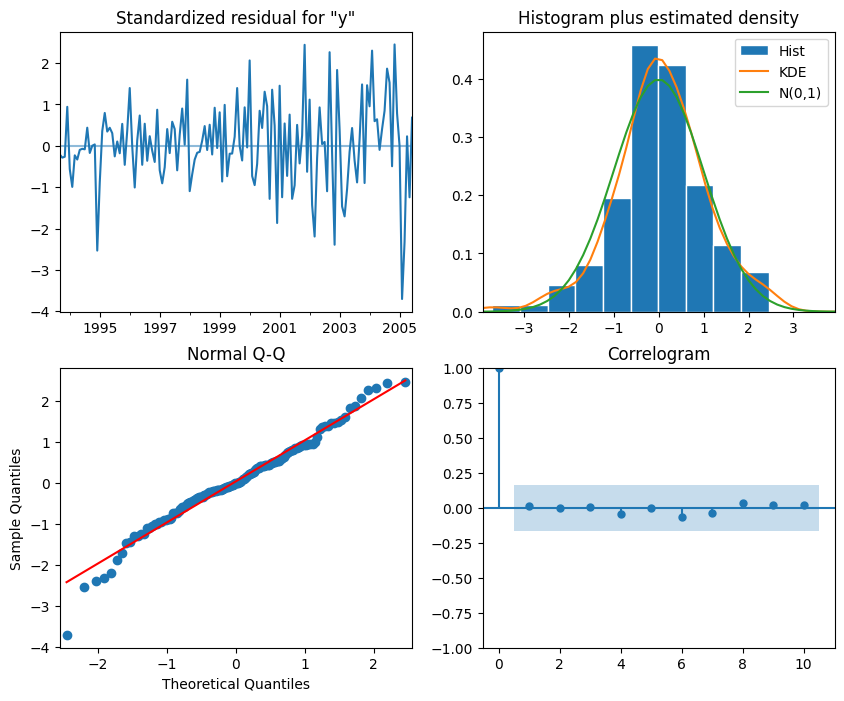

In [21]:
SARIMA_model = SARIMAX(train['y'], order=(2,1,3), seasonal_order=(2,1,0,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

#### The next step involves conducting the Ljung-Box test to assess the independence and lack of correlation in the residuals. The null hypothesis of this test posits that the residuals exhibit no correlation, akin to white noise. Therefore, the desired outcome is to obtain p-values greater than 0.05. If this condition is met, we retain the null hypothesis, indicating that the residuals are independent and exhibit characteristics typical of white noise.

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals_sarima = SARIMA_model_fit.resid
result_sarima = acorr_ljungbox(residuals_sarima, np.arange(1, 11, 1))
print("Result:", result_sarima)

Result:      lb_stat  lb_pvalue
1   0.017614   0.894416
2   0.280501   0.869141
3   0.315071   0.957170
4   0.409106   0.981725
5   0.414978   0.994907
6   2.068778   0.913266
7   2.069132   0.955915
8   2.069303   0.978813
9   2.121366   0.989400
10  2.139880   0.995151


#### All the p-values are above 0.05, so we do not reject the null hypothesis, and we conclude that the residuals are independent and uncorrelated. We can conclude that the model can used for forecasting.

#### Forecasting

In [47]:
forecast = SARIMA_model_fit.get_forecast(steps=len(test))
forecasted_values = forecast.predicted_mean
forecasted_values

2005-07-01    16.543418
2005-08-01    16.302451
2005-09-01    17.259482
2005-10-01    17.911166
2005-11-01    18.100217
2005-12-01    19.985662
2006-01-01    21.703813
2006-02-01    13.842606
2006-03-01    15.138599
2006-04-01    15.703379
2006-05-01    16.366290
2006-06-01    16.942106
2006-07-01    17.926207
2006-08-01    17.607000
2006-09-01    18.533865
2006-10-01    19.353482
2006-11-01    19.415808
2006-12-01    21.337876
2007-01-01    23.115969
2007-02-01    15.342272
2007-03-01    16.580390
2007-04-01    17.189909
2007-05-01    17.812962
2007-06-01    18.352407
2007-07-01    19.413053
2007-08-01    19.156621
2007-09-01    20.036965
2007-10-01    20.803632
2007-11-01    21.049280
2007-12-01    22.813175
2008-01-01    24.624611
2008-02-01    16.685225
2008-03-01    17.913535
2008-04-01    18.606159
2008-05-01    19.198371
2008-06-01    19.791755
Freq: MS, Name: predicted_mean, dtype: float64

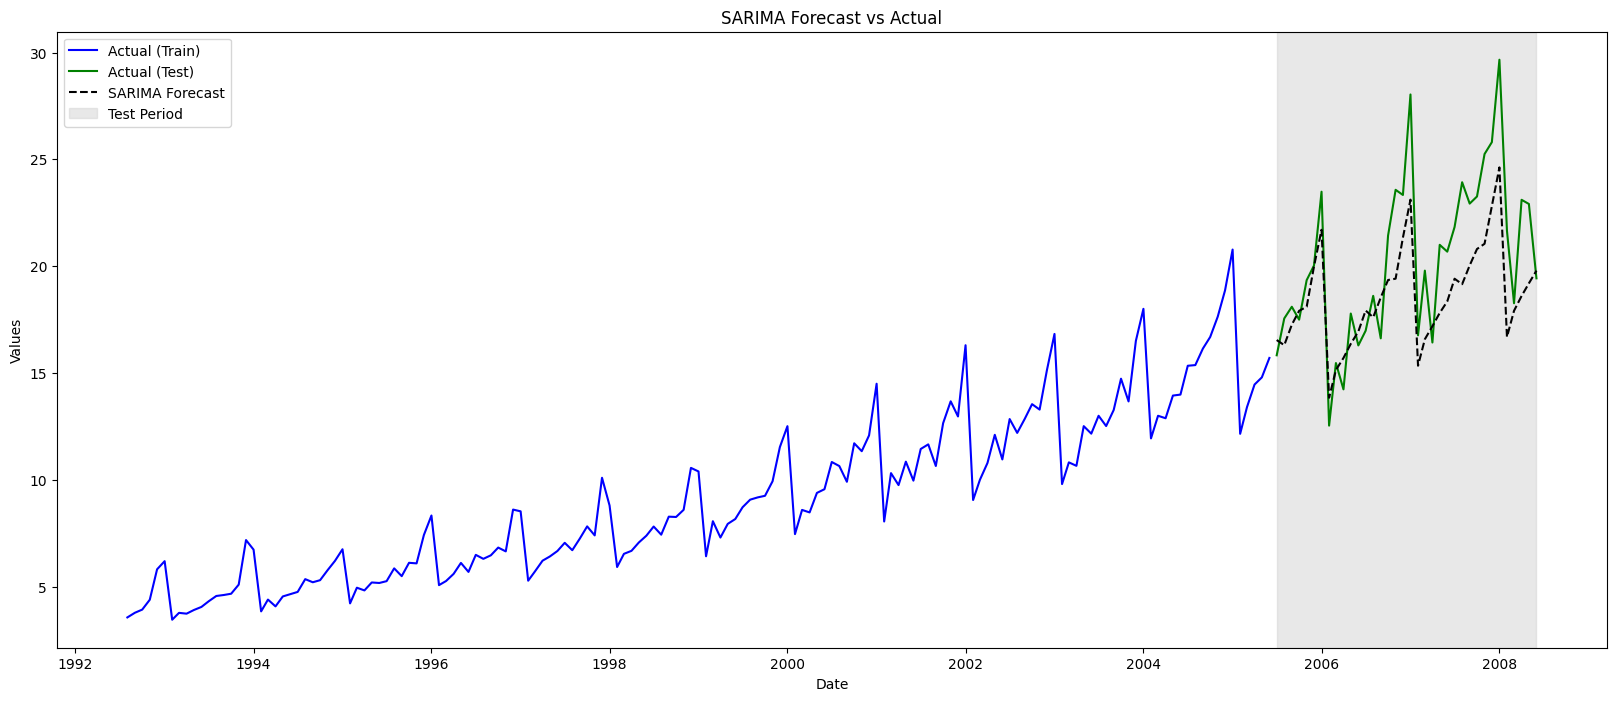

In [49]:
plt.figure(figsize=(20, 8))
plt.plot(train.index, train['y'], label='Actual (Train)', color='blue')
plt.plot(test.index, test['y'], label='Actual (Test)', color='green')

plt.plot(test.index, forecasted_values, label='SARIMA Forecast', color='black', linestyle='--')

plt.axvspan(test.index[0], test.index[-1], color='lightgrey', alpha=0.5, label='Test Period')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.show()


In [55]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(test['y'], forecasted_values)
rmse = root_mean_squared_error(test['y'], forecasted_values)
mape = mean_absolute_percentage_error(test['y'], forecasted_values)

print("Evaluation Metrics")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {100 * mape:.2f} %\n")

Evaluation Metrics
MAE: 2.17
RMSE: 2.65
MAPE: 10.04 %

